In [1]:
pip install mne torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:


import os
from os.path import dirname, join as pjoin
import scipy as sp
import scipy.io as sio
from scipy import signal
import numpy as np
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import networkx as nx
import torch as torch
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_classif
from scipy.integrate import simpson
from sklearn.model_selection import KFold
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, GAT, GraphNorm
from torch_geometric.nn import global_mean_pool
from torch import nn
from tqdm import tqdm
from torch_geometric.data import Data



In [3]:
# --- Core Libraries ---
import numpy as np
import scipy.io as sio
from scipy import signal as sig
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import networkx as nx
import os
from os.path import join as pjoin

# --- PyTorch & PyG Libraries ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool, GraphNorm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# --- Scikit-learn for Evaluation ---
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

# --- MNE for Topographical Plots (Crucial for Visualization) ---
import mne

# --- GPU Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Matplotlib plotting style ---
plt.style.use('seaborn-v0_8-whitegrid')
print("All libraries imported and device is set.")

Using device: cpu
All libraries imported and device is set.


In [4]:
def load_bci_competition_data(data_dir, subject_number):
    """
    Load BCI Competition IV Dataset 2a and convert to the expected format.
    
    Args:
        data_dir: Directory containing the .mat files
        subject_number: Subject number (1-9)
    
    Returns:
        subject_data: Dictionary with 'L' and 'R' keys containing trial data
    """
    mat_fname = pjoin(data_dir, f'A0{subject_number}T.mat')
    mat_contents = sio.loadmat(mat_fname, squeeze_me=True, struct_as_record=False)
    data = mat_contents['data']
    
    left_trials = []
    right_trials = []
    
    for session in data:
        # We are only interested in the training sessions which have labels
        if 'X' in session._fieldnames:
             eeg_data = session.X
             trial_positions = session.trial
             trial_labels = session.y
             
             # Use only the 22 EEG channels
             eeg_data = eeg_data[:, :22]
             
             # Extract trials (4 seconds * 250 Hz = 1000 samples)
             trial_length = 1000
             
             for start_pos, label in zip(trial_positions, trial_labels):
                 start_sample = int(start_pos)
                 end_sample = start_sample + trial_length
                 
                 if end_sample <= eeg_data.shape[0]:
                     trial_data = eeg_data[start_sample:end_sample, :]
                     
                     if label == 1: # Left hand
                         left_trials.append(trial_data)
                     elif label == 2: # Right hand
                         right_trials.append(trial_data)
    
    # Convert to the expected format (list of numpy arrays)
    subject_data = {
        'L': left_trials,
        'R': right_trials
    }
    
    return subject_data

# --- Example Usage ---
# Note: Adjust the path to where your data is stored on Kaggle.
data_dir = '/kaggle/input/bci-competition-iv-data-sets-2a'
subject_1_data_raw = load_bci_competition_data(data_dir, 1)

print(f"Loaded data for Subject 1.")
print(f"Number of Left hand MI trials: {len(subject_1_data_raw['L'])}")
print(f"Number of Right hand MI trials: {len(subject_1_data_raw['R'])}")
print(f"Shape of a single trial: {subject_1_data_raw['L'][0].shape}")
print(f"(Time Samples, EEG Channels)")

Loaded data for Subject 1.
Number of Left hand MI trials: 72
Number of Right hand MI trials: 72
Shape of a single trial: (1000, 22)
(Time Samples, EEG Channels)


In [5]:
# Full channel list (22 EEG channels in BCI Competition IV 2a, standard order)
full_channel_names = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4',
    'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
    'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'P1', 'Pz', 'P2', 'POz'
]

# Example: subset you want to keep
subset_channel_names = ['C3', 'Cz', 'C4']


In [6]:
import numpy as np

def select_channels(subject_data, full_channel_names, selected_channel_names):
    """
    Select a subset of EEG channels from the subject_data dictionary.

    Args:
        subject_data: dict with 'L' and 'R' keys (each a list of np.arrays [samples, channels])
        full_channel_names: list of all channel names in the original order
        selected_channel_names: list of channel names to keep

    Returns:
        new_subject_data: dict with only selected channels
    """
    # Get indices for the selected channels
    indices = [full_channel_names.index(ch) for ch in selected_channel_names if ch in full_channel_names]
    
    # Filter each trial
    filtered_data = {
        'L': [trial[:, indices] for trial in subject_data['L']],
        'R': [trial[:, indices] for trial in subject_data['R']]
    }
    
    print(f"Selected channels ({len(indices)}): {selected_channel_names}")
    return filtered_data


In [7]:
subject_1_data_subset = select_channels(
    subject_1_data_raw,
    full_channel_names,
    subset_channel_names
)

print(f"Shape of one left-hand trial after selection: {subject_1_data_subset['L'][0].shape}")


Selected channels (3): ['C3', 'Cz', 'C4']
Shape of one left-hand trial after selection: (1000, 3)


Applied bandpass filter (8-30 Hz) to all trials.


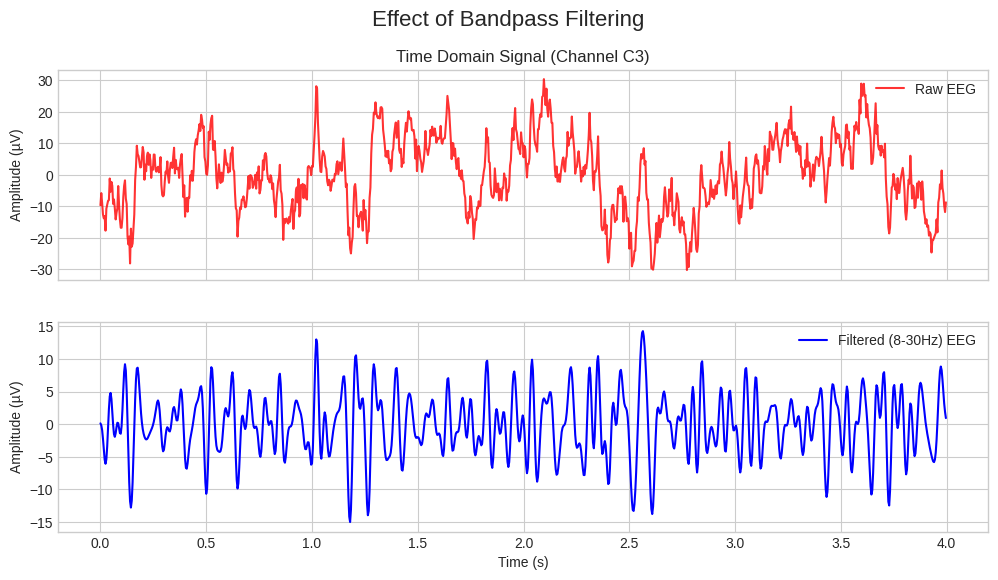

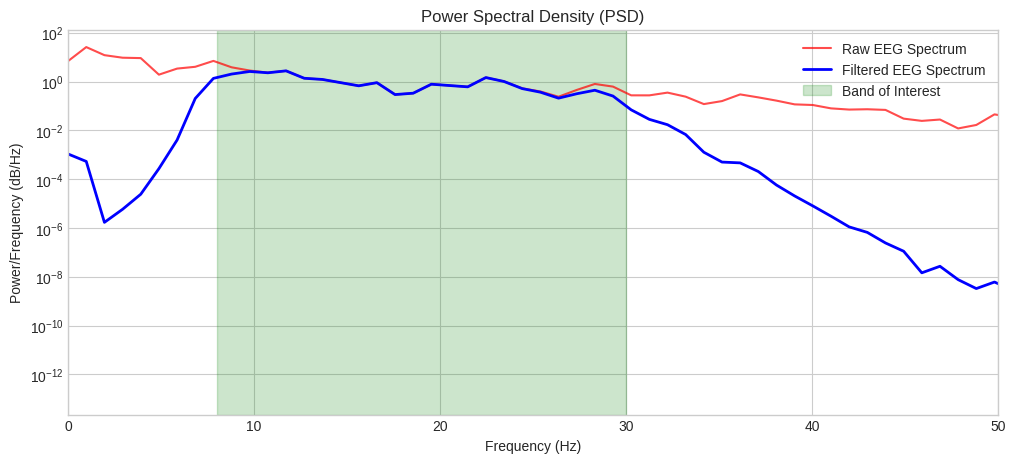

In [8]:
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    """Apply a bandpass filter to the data."""
    sos = sig.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sig.sosfiltfilt(sos, data, axis=0)
    return filtered_data

# --- Create a copy for processing ---
subject_1_data_processed = {
    'L': [trial.copy() for trial in subject_1_data_raw['L']],
    'R': [trial.copy() for trial in subject_1_data_raw['R']]
}

# --- Apply Bandpass Filter ---
fs = 250  # Sampling frequency
freq_band = [8, 30] # Mu and Beta rhythm band
for class_key in subject_1_data_processed:
    for i in range(len(subject_1_data_processed[class_key])):
        subject_1_data_processed[class_key][i] = bandpass(
            subject_1_data_processed[class_key][i], freq_band, fs
        )

print("Applied bandpass filter (8-30 Hz) to all trials.")

# --- Visualization of Filtering ---
# Select one trial and one channel to visualize
trial_raw = subject_1_data_raw['L'][0]
trial_filtered = subject_1_data_processed['L'][0]
channel_idx = 8 # C3 electrode

# 1. Time Domain Plot
time = np.arange(trial_raw.shape[0]) / fs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(time, trial_raw[:, channel_idx], label='Raw EEG', color='red', alpha=0.8)
ax1.set_title(f'Time Domain Signal (Channel C3)')
ax1.set_ylabel('Amplitude (µV)')
ax1.legend()
ax2.plot(time, trial_filtered[:, channel_idx], label='Filtered (8-30Hz) EEG', color='blue')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (µV)')
ax2.legend()
plt.suptitle('Effect of Bandpass Filtering', fontsize=16)
plt.show()


# 2. Frequency Domain Plot (Power Spectral Density)
freqs_raw, psd_raw = sig.welch(trial_raw[:, channel_idx], fs)
freqs_filt, psd_filt = sig.welch(trial_filtered[:, channel_idx], fs)
fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(freqs_raw, psd_raw, label='Raw EEG Spectrum', color='red', alpha=0.7)
ax.semilogy(freqs_filt, psd_filt, label='Filtered EEG Spectrum', color='blue', linewidth=2)
ax.axvspan(freq_band[0], freq_band[1], color='green', alpha=0.2, label='Band of Interest')
ax.set_title('Power Spectral Density (PSD)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency (dB/Hz)')
ax.set_xlim(0, 50)
ax.legend()
plt.show()

Computing PLV for L trials:   0%|          | 0/72 [00:00<?, ?it/s]

Computing PLV for R trials:   0%|          | 0/72 [00:00<?, ?it/s]


Computed PLV matrices. Average Left PLV matrix shape: (22, 22)


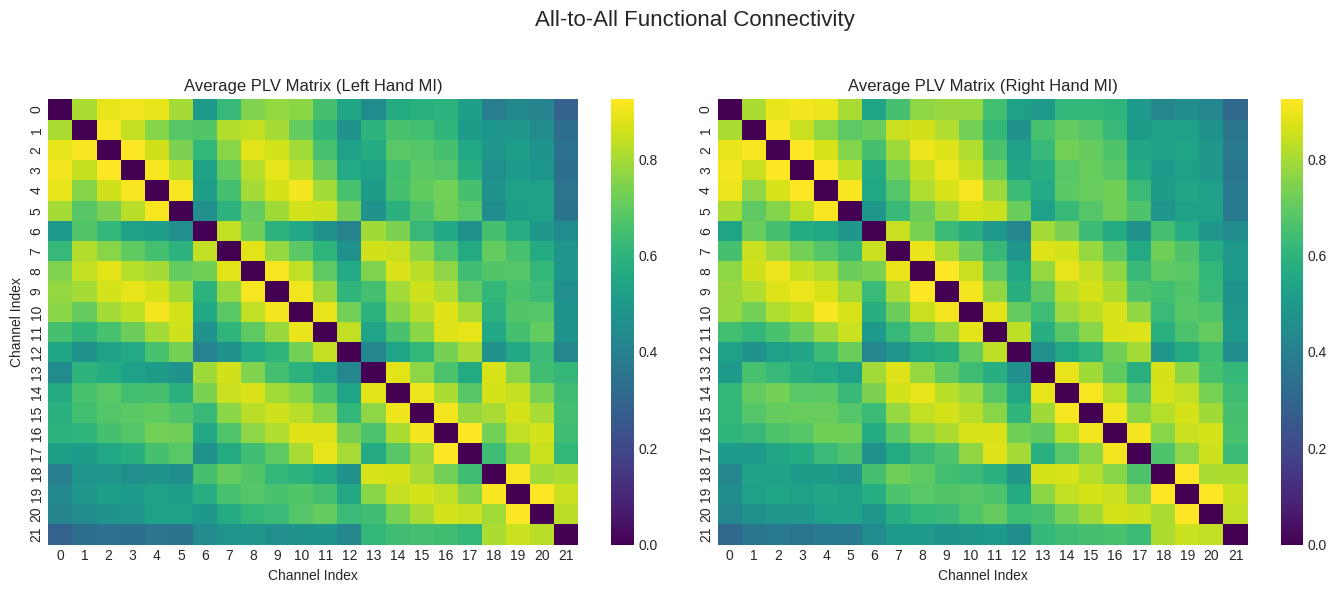

/tmp/ipykernel_37/1334592515.py:100: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


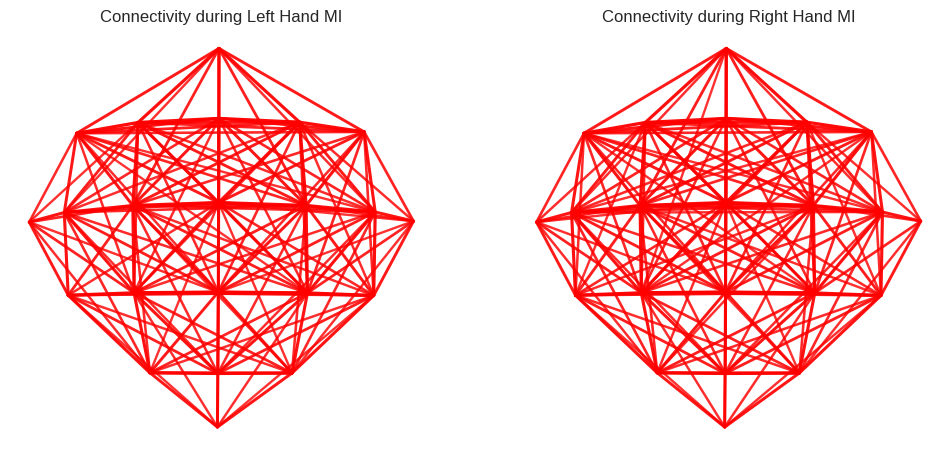

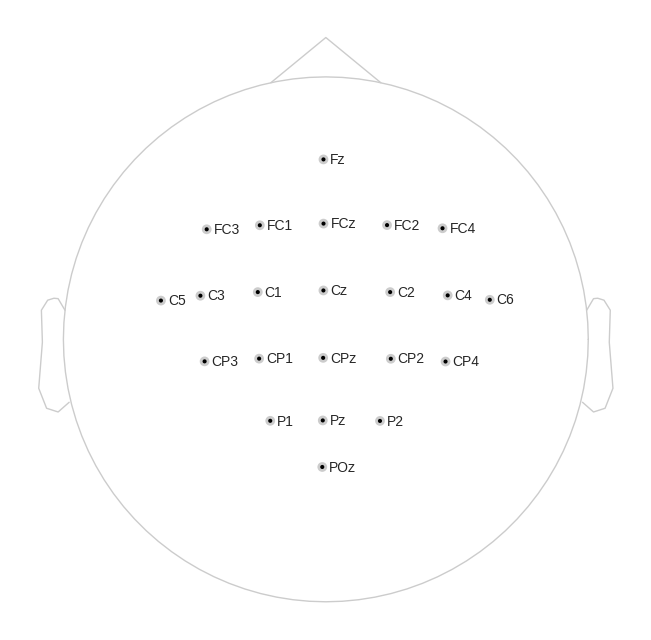

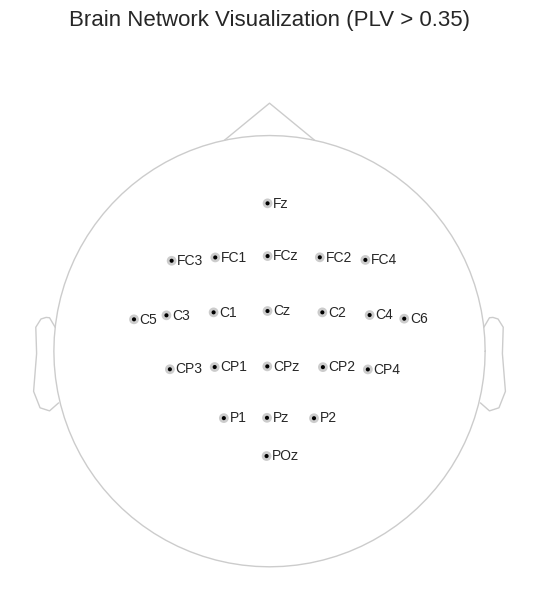

MONTAGE VISUALIZATION CODE DIDNT WORK HENCE THE GRAPH AND THE ELECTRODE PLACEMENT IS NOT SHOW TOGETHER


In [9]:
def plvfcn(eeg_data):
    """
    Calculates the Phase Locking Value (PLV) matrix for a single trial.
    """
    num_channels = eeg_data.shape[1]
    num_samples = eeg_data.shape[0]
    analytic_signal = sig.hilbert(eeg_data, axis=0)
    instantaneous_phase = np.angle(analytic_signal)
    
    plv_matrix = np.zeros((num_channels, num_channels))
    for i in range(num_channels):
        for j in range(i + 1, num_channels):
            phase_diff = instantaneous_phase[:, i] - instantaneous_phase[:, j]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / num_samples)
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv
            
    return plv_matrix

def compute_all_plv_matrices(filtered_data):
    """
    Computes PLV matrices for all trials in the dataset.
    """
    all_plv = {'L': [], 'R': []}
    for class_key in filtered_data:
        for trial_data in tqdm(filtered_data[class_key], desc=f'Computing PLV for {class_key} trials'):
            plv_matrix = plvfcn(trial_data)
            all_plv[class_key].append(plv_matrix)
    return all_plv

# --- Compute PLV for our processed data ---
subject_1_plv = compute_all_plv_matrices(subject_1_data_processed)

# --- Average PLV matrices for visualization ---
avg_plv_L = np.mean(subject_1_plv['L'], axis=0)
avg_plv_R = np.mean(subject_1_plv['R'], axis=0)

print(f"\nComputed PLV matrices. Average Left PLV matrix shape: {avg_plv_L.shape}")

# --- VISUALIZATION 1: PLV Matrix Heatmap ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Plotting code for heatmaps remains the same...
sns.heatmap(avg_plv_L, ax=ax1, cmap='viridis', vmin=0, vmax=np.max([avg_plv_L, avg_plv_R]))
ax1.set_title('Average PLV Matrix (Left Hand MI)')
ax1.set_xlabel('Channel Index'); ax1.set_ylabel('Channel Index')
sns.heatmap(avg_plv_R, ax=ax2, cmap='viridis', vmin=0, vmax=np.max([avg_plv_L, avg_plv_R]))
ax2.set_title('Average PLV Matrix (Right Hand MI)')
ax2.set_xlabel('Channel Index');
plt.suptitle('All-to-All Functional Connectivity', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


# --- VISUALIZATION 2: Topographical Connectivity Plot (Final Corrected Version) ---
ch_names = full_channel_names#['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fz']
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1005')
info.set_montage(montage)

# This is our new, robust plotting function
def plot_brain_connectivity(plv_matrix, ax, title, threshold=0.6):
    """
    Plots brain connectivity on a 2D sensor layout.
    """
    # Use mne.viz.plot_sensors to draw the channel locations on the given axes
    # This is the corrected line that fixes the TypeError
    mne.viz.plot_sensors(info, kind='topomap', ch_type='eeg', show_names=True, show=False)
    
    # Get the 2D sensor positions from the info object's montage
    ch_coords = info.get_montage().get_positions()['ch_pos']
    pos = np.array([ch_coords[ch] for ch in info['ch_names']])

    # Find connections above the threshold
    source, target = np.where(plv_matrix > threshold)
    
    # Plot the connections
    for i in range(len(source)):
        # We only plot each connection once
        if source[i] > target[i]:
            x1, y1 = pos[source[i], :2]
            x2, y2 = pos[target[i], :2]
            
            weight = plv_matrix[source[i], target[i]]
            
            ax.plot([x1, x2], [y1, y2], 
                    color='red', 
                    linewidth=0.5 + 2 * weight,
                    alpha=0.5 + 0.5 * weight)

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


# Plotting the brain networks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'aspect': 'equal'})
plot_brain_connectivity(avg_plv_L, ax1, 'Connectivity during Left Hand MI')
plot_brain_connectivity(avg_plv_R, ax2, 'Connectivity during Right Hand MI')
plt.suptitle('Brain Network Visualization (PLV > 0.35)', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


print("MONTAGE VISUALIZATION CODE DIDNT WORK HENCE THE GRAPH AND THE ELECTRODE PLACEMENT IS NOT SHOW TOGETHER")

Calculating features for L trials:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating features for R trials:   0%|          | 0/72 [00:00<?, ?it/s]


Calculated features. Shape of features for one trial: (22, 8)
(Channels, Frequency Bands)


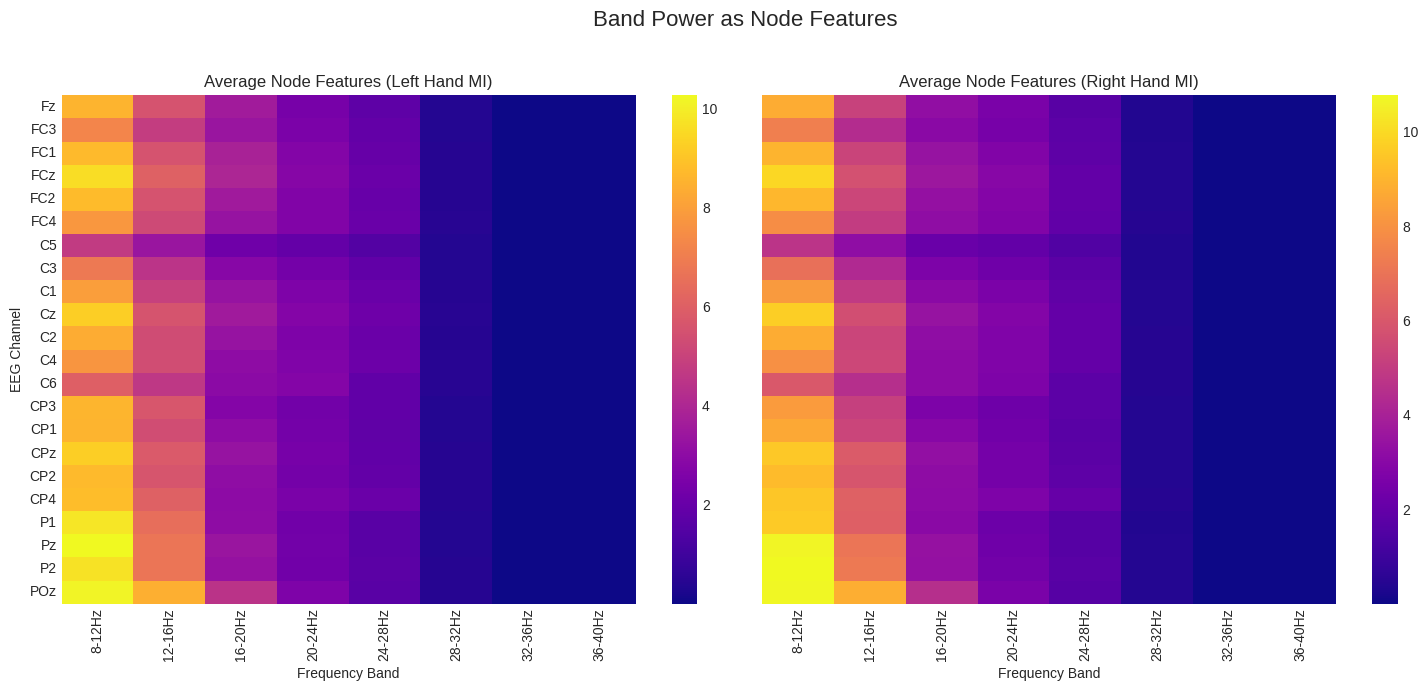

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


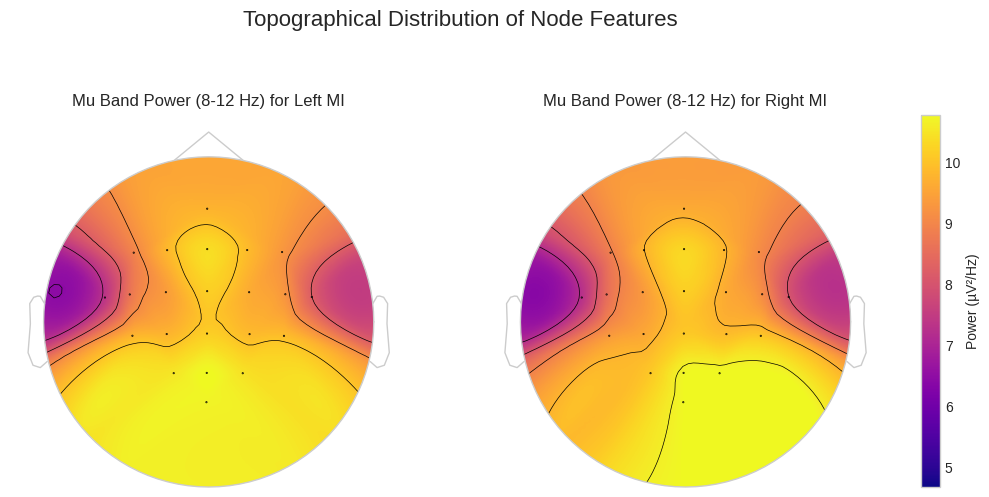

In [10]:
def bandpower(data, low, high, fs=250):
    """
    Calculate band power using Welch's method and Simpson's rule for integration.
    
    Args:
        data (1D array): Time-series data for a single channel.
        low (float): Lower frequency bound.
        high (float): Upper frequency bound.
        fs (int): Sampling frequency.
        
    Returns:
        power (float): The absolute power in the specified frequency band.
    """
    # Use a window of 1 second (250 samples) for Welch's method
    win_len = fs
    freqs, psd = sig.welch(data, fs, nperseg=min(win_len, len(data)))
    
    # Find the indices of frequencies within our band of interest
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute power by integrating the PSD using Simpson's rule (more accurate)
    power = simpson(psd[idx_band], dx=freq_res)
    
    return power

def calculate_band_power_features(filtered_data):
    """
    Calculates band power features for all trials.
    """
    # Define frequency bands of 4 Hz width from 8 Hz to 40 Hz
    bands = list(range(8, 41, 4)) # [8, 12, 16, 20, 24, 28, 32, 36, 40]
    num_bands = len(bands) - 1
    
    features = {'L': [], 'R': []}
    
    for class_key in filtered_data:
        for trial_data in tqdm(filtered_data[class_key], desc=f'Calculating features for {class_key} trials'):
            num_channels = trial_data.shape[1]
            trial_features = np.zeros((num_channels, num_bands))
            
            for ch_idx in range(num_channels):
                for band_idx in range(num_bands):
                    low_freq = bands[band_idx]
                    high_freq = bands[band_idx+1]
                    trial_features[ch_idx, band_idx] = bandpower(trial_data[:, ch_idx], low_freq, high_freq)
            
            features[class_key].append(trial_features)
            
    return features, bands

# --- Calculate features and define bands ---
subject_1_features, freq_bands = calculate_band_power_features(subject_1_data_processed)
print(f"\nCalculated features. Shape of features for one trial: {subject_1_features['L'][0].shape}")
print(f"(Channels, Frequency Bands)")

# --- VISUALIZATION 1: Feature Heatmap ---
avg_feat_L = np.mean(subject_1_features['L'], axis=0)
avg_feat_R = np.mean(subject_1_features['R'], axis=0)
band_labels = [f'{freq_bands[i]}-{freq_bands[i+1]}Hz' for i in range(len(freq_bands)-1)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
sns.heatmap(avg_feat_L, yticklabels=ch_names, xticklabels=band_labels, cmap='plasma', ax=ax1)
ax1.set_title('Average Node Features (Left Hand MI)')
ax1.set_ylabel('EEG Channel')
ax1.set_xlabel('Frequency Band')

sns.heatmap(avg_feat_R, yticklabels=False, xticklabels=band_labels, cmap='plasma', ax=ax2)
ax2.set_title('Average Node Features (Right Hand MI)')
ax2.set_xlabel('Frequency Band')

plt.suptitle('Band Power as Node Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- VISUALIZATION 2: Topographical Power Map ---
# Let's visualize power in the Mu band (8-12 Hz), which is the first band (index 0)
mu_power_L = avg_feat_L[:, 0]
mu_power_R = avg_feat_R[:, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mne.viz.plot_topomap(mu_power_L, info, axes=ax1, show=False, cmap='plasma')
ax1.set_title('Mu Band Power (8-12 Hz) for Left MI')
mne.viz.plot_topomap(mu_power_R, info, axes=ax2, show=False, cmap='plasma')
ax2.set_title('Mu Band Power (8-12 Hz) for Right MI')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=min(mu_power_L.min(), mu_power_R.min()), 
                                                            vmax=max(mu_power_L.max(), mu_power_R.max())))
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Power (µV²/Hz)')

plt.suptitle('Topographical Distribution of Node Features', fontsize=16)
plt.show()

In [11]:
from torch_geometric.utils import dense_to_sparse

# We will create a fully connected graph for each trial initially.
# The edge_weights will be the PLV values. The GAT's attention
# mechanism will then learn which of these connections are important.

data_list = []
# Process Left Hand trials (label 0)
for i in range(len(subject_1_plv['L'])):
    # Node features: [num_channels, num_features]
    x = torch.tensor(subject_1_features['L'][i], dtype=torch.float)
    
    # Adjacency matrix: [num_channels, num_channels]
    adj = torch.tensor(subject_1_plv['L'][i], dtype=torch.float)
    
    # Convert dense adjacency matrix to sparse edge_index and edge_attr
    edge_index, edge_attr = dense_to_sparse(adj)
    
    # Label
    y = torch.tensor([0], dtype=torch.long)
    
    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

# Process Right Hand trials (label 1)
for i in range(len(subject_1_plv['R'])):
    x = torch.tensor(subject_1_features['R'][i], dtype=torch.float)
    adj = torch.tensor(subject_1_plv['R'][i], dtype=torch.float)
    edge_index, edge_attr = dense_to_sparse(adj)
    y = torch.tensor([1], dtype=torch.long)
    
    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

print(f"Total number of graphs (trials) created: {len(data_list)}")
print("\n--- Example Data Object ---")
print(data_list[0])
print("---------------------------")


Total number of graphs (trials) created: 144

--- Example Data Object ---
Data(x=[22, 8], edge_index=[2, 462], edge_attr=[462], y=[1])
---------------------------


In [12]:
from torch_geometric.utils import dense_to_sparse

# --- 1. Assemble Data into PyTorch Geometric's format ---


# --- 2. Define the GAT Model Architecture ---

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super(GAT, self).__init__()
        # We use GATv2Conv as it's a more powerful and stable version
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.gn1 = GraphNorm(hidden_channels * heads)
        
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.gn2 = GraphNorm(hidden_channels * heads)

        self.conv3 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.gn3 = GraphNorm(hidden_channels * heads)
        
        # Final classifier layer
        self.lin = nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index, edge_attr, batch, return_attention=False):
        # Layer 1
        x, att1 = self.conv1(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.leaky_relu(x)
        x = self.gn1(x, batch)
        
        # Layer 2
        x, att2 = self.conv2(x, edge_index, edge_attr, return_attention_weights=True)
        x = F.leaky_relu(x)
        x = self.gn2(x, batch)
        
        # Layer 3
        x, att3 = self.conv3(x, edge_index, edge_attr, return_attention_weights=True)
        x = self.gn3(x, batch)
        
        # Readout layer for graph-level classification
        x = global_mean_pool(x, batch)
        
        # Apply dropout for regularization
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Final classification
        x = self.lin(x)
        
        if return_attention:
            # Return final logits and the attention weights from all layers
            return F.log_softmax(x, dim=1), (att1, att2, att3)
        else:
            return F.log_softmax(x, dim=1)

# --- Instantiate the model and print its summary ---
# in_channels = number of node features (8 frequency bands)
# hidden_channels = an intermediate dimension
# out_channels = number of classes (2: Left/Right)
# heads = number of parallel attention mechanisms
model = GAT(in_channels=data_list[0].num_node_features, 
            hidden_channels=16, 
            out_channels=2, 
            heads=4)

print("\n--- GAT Model Architecture ---")
print(model)
print("----------------------------")


--- GAT Model Architecture ---
GAT(
  (conv1): GATv2Conv(8, 16, heads=4)
  (gn1): GraphNorm(64)
  (conv2): GATv2Conv(64, 16, heads=4)
  (gn2): GraphNorm(64)
  (conv3): GATv2Conv(64, 16, heads=4)
  (gn3): GraphNorm(64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------


In [13]:

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = sig.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sig.sosfiltfilt(sos, data,axis=0)
    return filtered_data

def plvfcn(eegData):
    numElectrodes = eegData.shape[1]
    numTimeSteps = eegData.shape[0]
    plvMatrix = np.zeros((numElectrodes, numElectrodes))
    for electrode1 in range(numElectrodes):
        for electrode2 in range(electrode1 + 1, numElectrodes):
            phase1 = np.angle(sig.hilbert(eegData[:, electrode1]))
            phase2 = np.angle(sig.hilbert(eegData[:, electrode2]))
            phase_difference = phase2 - phase1
            plv = np.abs(np.sum(np.exp(1j * phase_difference)) / numTimeSteps)
            plvMatrix[electrode1, electrode2] = plv
            plvMatrix[electrode2, electrode1] = plv
    return plvMatrix

def compute_plv(subject_data):
    idx = ['L', 'R']
    numElectrodes = subject_data['L'][0,0].shape[1]  # Fixed indexing
    
    # Get number of trials for each class
    num_trials_L = subject_data['L'].shape[1]
    num_trials_R = subject_data['R'].shape[1]
    
    plv = {
        'L': np.zeros((numElectrodes, numElectrodes, num_trials_L)), 
        'R': np.zeros((numElectrodes, numElectrodes, num_trials_R))
    }
    
    for field in idx:
        num_trials = subject_data[field].shape[1]
        for j in range(num_trials):
            x = subject_data[field][0, j]
            plv[field][:, :, j] = plvfcn(x)
    
    l, r = plv['L'], plv['R']
    yl = np.zeros((num_trials_L, 1))
    yr = np.ones((num_trials_R, 1))
    img = np.concatenate((l, r), axis=2)
    y = np.concatenate((yl, yr), axis=0)
    y = torch.tensor(y, dtype=torch.long)
    return img, y


def create_graphs(plv, threshold):
    
    graphs = []
    for i in range(plv.shape[2]):
        G = nx.Graph()
        G.add_nodes_from(range(plv.shape[0]))
        for u in range(plv.shape[0]):
            for v in range(plv.shape[0]):
                if u != v and plv[u, v, i] > threshold:
                    G.add_edge(u, v, weight=plv[u, v, i])
        graphs.append(G)
    return graphs



In [14]:
import numpy as np
import scipy.io as sio
from os.path import join as pjoin

def load_bci_competition_data(data_dir, subject_number, selected_channel_names=None):
    """
    Load BCI Competition IV Dataset 2a (test sessions 3-8) and convert to the expected format.
    Optionally select a subset of channels by name.

    Args:
        data_dir: Directory containing the .mat files
        subject_number: Subject number (1-9)
        selected_channel_names: list of channel names to keep (order preserved).
                                If None, keep default first 22 EEG channels.

    Returns:
        subject_data: Dictionary with keys:
          'L' : np.ndarray object array with left trials (shape (1, n_left))
          'R' : np.ndarray object array with right trials (shape (1, n_right))
          'ch_names': list of channel names used (length == n_channels)
    """
    # canonical 22-channel order commonly used for BCI IV-2a
    full_channel_names = [
        'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4',
        'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
        'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
        'P1', 'Pz', 'P2', 'POz'
    ]

    mat_fname = pjoin(data_dir, f'A0{subject_number}T.mat')
    mat_contents = sio.loadmat(mat_fname)
    data = mat_contents['data']

    # Initialize lists to store left and right hand trials
    left_trials = []
    right_trials = []

    # Process test sessions (indices 3-8) as in your original code
    for session_idx in range(3, 9):  # Sessions 3-8 contain test data
        sess = data[0, session_idx][0, 0]

        # your structure: sess[0] = eeg, sess[1] = trial_positions, sess[2] = labels
        eeg_data = sess[0]          # Shape: (time_samples, 25_channels) typically
        trial_positions = sess[1].flatten()  # Trial start positions
        trial_labels = sess[2].flatten()     # Trial labels

        # Only use first 22 channels (EEG, exclude EOG)
        if eeg_data.shape[1] >= 22:
            eeg_data_22 = eeg_data[:, :22]
        else:
            # fallback: use whatever channels are present
            eeg_data_22 = eeg_data.copy()

        # Extract trials (each trial is approximately 4 seconds = 1000 samples at 250Hz)
        trial_length = 1000  # 4 seconds * 250 Hz

        for start_pos, label in zip(trial_positions, trial_labels):
            start_sample = int(start_pos)
            end_sample = start_sample + trial_length

            # Extract trial data
            if end_sample <= eeg_data_22.shape[0]:
                trial_data = eeg_data_22[start_sample:end_sample, :]

                # Assign to left or right hand based on label
                if label == 1:  # Left hand
                    left_trials.append(trial_data)
                elif label == 2:  # Right hand
                    right_trials.append(trial_data)
                # Skip feet (3) and tongue (4) for binary classification

    # Determine which channel names to use and compute indices
    if selected_channel_names is None:
        ch_names_used = full_channel_names.copy()
    else:
        # Keep only names that exist in full list, preserving order given by selected_channel_names
        ch_names_used = [ch for ch in selected_channel_names if ch in full_channel_names]
        if len(ch_names_used) == 0:
            # fallback to full if selection empty or invalid
            print("Warning: no valid selected_channel_names found in canonical list — using default 22 channels.")
            ch_names_used = full_channel_names.copy()

    # Compute indices in the full 22-channel array
    indices = [full_channel_names.index(ch) for ch in ch_names_used]

    # Convert to the expected format: object arrays (same as your original)
    subject_data = {
        'L': np.empty((1, len(left_trials)), dtype=object),
        'R': np.empty((1, len(right_trials)), dtype=object),
        'ch_names': ch_names_used
    }

    # Fill the arrays with selected-channel slices
    for i, trial in enumerate(left_trials):
        # trial shape: (n_samples, 22) or fewer if file had fewer channels
        # guard: if trial has fewer channels than expected, try to select available indices
        max_ch = trial.shape[1]
        valid_idx = [idx for idx in indices if idx < max_ch]
        if len(valid_idx) == 0:
            # nothing to select, keep empty array
            subject_data['L'][0, i] = np.empty((trial.shape[0], 0))
        else:
            subject_data['L'][0, i] = trial[:, valid_idx]

    for i, trial in enumerate(right_trials):
        max_ch = trial.shape[1]
        valid_idx = [idx for idx in indices if idx < max_ch]
        if len(valid_idx) == 0:
            subject_data['R'][0, i] = np.empty((trial.shape[0], 0))
        else:
            subject_data['R'][0, i] = trial[:, valid_idx]

    return subject_data
data_dir = r'/kaggle/input/bci-competition-iv-data-sets-2a'
subset = ['C3', 'Cz', 'C4']
test_subject_sub = load_bci_competition_data(data_dir, 1, selected_channel_names=subset)
print("Used channels:", test_subject_sub['ch_names'])
print("Trial shape after selection:", test_subject_sub['L'][0,0].shape)  # (1000, 3)


Used channels: ['C3', 'Cz', 'C4']
Trial shape after selection: (1000, 3)


In [15]:
def aggregate_eeg_data(S1, band): 
    """
    Aggregate EEG data for each class.
    Adapted for BCI Competition IV Dataset 2a format.
    """
    idx = ['L', 'R']
    numElectrodes = S1['L'][0,0].shape[1]  # Should be 22 for this dataset
    
    # Find the maximum trial length (should be consistent at 1000 samples)
    max_sizes = {field: 0 for field in idx}
    for field in idx:
        for i in range(S1[field].shape[1]):
            max_sizes[field] = max(max_sizes[field], S1[field][0, i].shape[0])

    # Initialize arrays to store aggregated EEG data
    l = np.zeros((max_sizes['L'], numElectrodes, S1['L'].shape[1]))
    r = np.zeros((max_sizes['R'], numElectrodes, S1['R'].shape[1]))

    # Loop through each trial
    for i in range(S1['L'].shape[1]):
        x = S1['L'][0, i]  # EEG data for the current trial
        l[:x.shape[0], :, i] = x

    for i in range(S1['R'].shape[1]):
        x = S1['R'][0, i]  # EEG data for the current trial
        r[:x.shape[0], :, i] = x

    # Add frequency band dimension
    l = l[..., np.newaxis]
    l = np.tile(l, (1, 1, 1, len(band)-1))

    r = r[..., np.newaxis]
    r = np.tile(r, (1, 1, 1, len(band)-1))
    
    return l, r

def bandpass1(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = sig.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sig.sosfiltfilt(sos, data)
    return filtered_data

def bandpower(data, low, high, fs=250):
    """Calculate band power using Welch's method"""
    # Define window length (2s)
    win = 2 * fs
    freqs, psd = signal.welch(data, fs, nperseg=min(win, len(data)))
    
    # Find intersecting values in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Compute the absolute power by approximating the area under the curve
    power = simpson(psd[idx_band], dx=freq_res)
    
    return power

def bandpowercalc(l, band, fs):   
    x = np.zeros([l.shape[0], l.shape[3], l.shape[2]])
    for i in range(l.shape[0]):  # node/channel
        for j in range(l.shape[2]):  # trial/sample
            for k in range(l.shape[3]):  # frequency band
                data = l[i, :, j, k]
                low = band[k]
                high = band[k+1]
                x[i, k, j] = bandpower(data, low, high, fs)
    return x


In [17]:
class GAT(nn.Module):
    def __init__(self, hidden_channels, heads):
        super(GAT, self).__init__()
        
        self.conv1 = GATv2Conv(len(band)-1, hidden_channels, heads=heads, concat=True)  # 8 frequency bands
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True)
        self.conv3 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True)
        
        self.gn1 = GraphNorm(hidden_channels * heads)
        self.gn2 = GraphNorm(hidden_channels * heads)
        self.gn3 = GraphNorm(hidden_channels * heads)
        
        self.lin = nn.Linear(hidden_channels * heads, 2)  # Binary classification
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.gn1(x, batch)
    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.gn2(x, batch)
    
        x = self.conv3(x, edge_index)
        x = self.gn3(x, batch)
    
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.50, training=self.training)
        x = self.lin(x)
    
        return x

from scipy.signal import butter, sosfiltfilt

def safe_bandpass(x, band, fs, order=4):
    """
    Bandpass filter that works for short signals by mirroring (reflect) padding.
    Accepts 1D (time,) or 2D (time, channels) arrays. Returns same shape as input.
    """
    low, high = band
    # design SOS (numerically stable)
    sos = butter(order, [low, high], btype='band', fs=fs, output='sos')

    # also get b,a to compute padlen used by filtfilt (sosfiltfilt uses same pad logic)
    b, a = butter(order, [low / (fs / 2), high / (fs / 2)], btype='band')
    padlen = 3 * (max(len(a), len(b)) - 1)

    x_arr = np.asarray(x)
    if x_arr.ndim == 1:
        orig_len = x_arr.shape[0]
        need_pad = orig_len <= padlen
        if need_pad:
            p = padlen + 1  # ensure > padlen after padding
            xpad = np.pad(x_arr, (p, p), mode='reflect')
            ypad = sosfiltfilt(sos, xpad, axis=0)
            y = ypad[p:p+orig_len]
        else:
            y = sosfiltfilt(sos, x_arr, axis=0)
    elif x_arr.ndim == 2:
        orig_len = x_arr.shape[0]
        need_pad = orig_len <= padlen
        if need_pad:
            p = padlen + 1
            xpad = np.pad(x_arr, ((p, p), (0, 0)), mode='reflect')
            ypad = sosfiltfilt(sos, xpad, axis=0)
            y = ypad[p:p+orig_len, :]
        else:
            y = sosfiltfilt(sos, x_arr, axis=0)
    else:
        raise ValueError("safe_bandpass: input must be 1D or 2D (time[, channels])")

    return y


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


Using device: cpu


Processing Subjects:   0%|          | 0/8 [00:00<?, ?it/s]

10


Training Subject 1 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 1 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S1: Mean: 0.7219, Max: 0.8000, Min: 0.6429
10


Training Subject 2 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 2 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S2: Mean: 0.7662, Max: 0.9286, Min: 0.5333
10


Training Subject 3 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 3 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S3: Mean: 0.7919, Max: 0.8571, Min: 0.7143
10


Training Subject 5 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 5 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S5: Mean: 0.7486, Max: 0.9333, Min: 0.6429
10


Training Subject 6 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 6 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S6: Mean: 0.7671, Max: 0.9286, Min: 0.6000
10


Training Subject 7 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 7 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S7: Mean: 0.7086, Max: 0.9333, Min: 0.4000
10


Training Subject 8 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 8 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S8: Mean: 0.7714, Max: 0.8667, Min: 0.6000
10


Training Subject 9 Fold 1:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 2:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 3:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 4:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 5:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 6:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 7:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 8:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 9:   0%|          | 0/249 [00:00<?, ?it/s]

Training Subject 9 Fold 10:   0%|          | 0/249 [00:00<?, ?it/s]

S9: Mean: 0.7795, Max: 0.8571, Min: 0.6000

Summary of Results for All Subjects:
S1: Mean: 0.7219, Max: 0.8000, Min: 0.6429
S2: Mean: 0.7662, Max: 0.9286, Min: 0.5333
S3: Mean: 0.7919, Max: 0.8571, Min: 0.7143
S5: Mean: 0.7486, Max: 0.9333, Min: 0.6429
S6: Mean: 0.7671, Max: 0.9286, Min: 0.6000
S7: Mean: 0.7086, Max: 0.9333, Min: 0.4000
S8: Mean: 0.7714, Max: 0.8667, Min: 0.6000
S9: Mean: 0.7795, Max: 0.8571, Min: 0.6000

Results saved to 'BCI_IV_2a_GAT_Results.json'


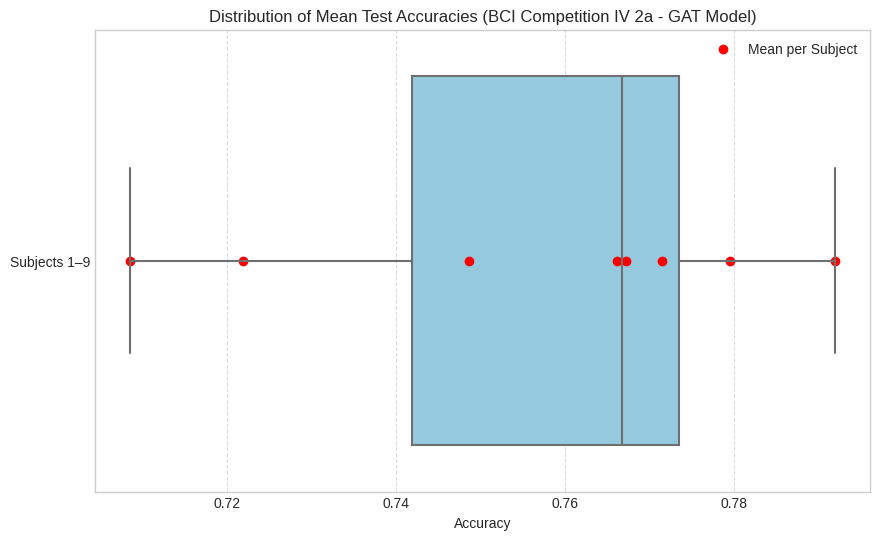

In [19]:
import json

subset=["FC3", "FC4","C5", "C6","C3", "C4","C1", "C2","CP3", "CP4"]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================
# MAIN PIPELINE
# ==============================
data_dir = r'/kaggle/input/bci-competition-iv-data-sets-2a'
subject_numbers = [1,2,3,5,6,7,8,9]   # Subjects 1-9
subject_results = {}

# Process each subject
for subject_number in tqdm(subject_numbers, desc="Processing Subjects"):
    # Load data using your custom function
    S1 = load_bci_competition_data(data_dir, subject_number,selected_channel_names=subset)
    
    # Apply bandpass filtering
    fs = 250  # Sampling frequency for BCI Competition IV Dataset 2a
    idx = ['L', 'R']
    for key in idx:
        for i in range(S1[key].shape[1]):
            S1[key][0, i] = bandpass(S1[key][0, i], [8, 30], fs)
    
    # Compute PLV and create graphs
    plv, y = compute_plv(S1)
    threshold = 0.5
    graphs = create_graphs(plv, threshold)
    numElectrodes = S1['L'][0, 0].shape[1]  # Should be 22
    print(numElectrodes)
    # Create adjacency matrices
    adj = np.zeros([numElectrodes, numElectrodes, len(graphs)])
    for i, G in enumerate(graphs):
        adj[:, :, i] = nx.to_numpy_array(G)
    
    # Create edge indices for PyTorch Geometric
    edge_indices = []
    for i in range(adj.shape[2]):
        source_nodes, target_nodes = [], []
        for row in range(adj.shape[0]):
            for col in range(adj.shape[1]):
                if adj[row, col, i] >= threshold:
                    source_nodes.append(row)
                    target_nodes.append(col)
                else:
                    source_nodes.append(0)
                    target_nodes.append(0)
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        edge_indices.append(edge_index)

    edge_indices = torch.stack(edge_indices, dim=-1)
    
    # Frequency band analysis
    band = list(range(8, 41, 4))  # [8, 12, 16, 20, 24, 28, 32, 36, 40]
    l, r = aggregate_eeg_data(S1, band)
    l, r = np.transpose(l, [1, 0, 2, 3]), np.transpose(r, [1, 0, 2, 3])
    
    for i in range(l.shape[3]):
        bp = [band[i], band[i+1]]
        for j in range(l.shape[2]):
            l[:, :, j, i] = bandpass1(l[:, :, j, i], bp, sample_rate=fs)
            r[:, :, j, i] = bandpass1(r[:, :, j, i], bp, sample_rate=fs)
    
    l = bandpowercalc(l, band, fs)
    r = bandpowercalc(r, band, fs)

    # Combine left and right hand data
    x = np.concatenate([l, r], axis=2)
    x = torch.tensor(x, dtype=torch.float32)

    # Create PyTorch Geometric data objects
    data_list = []
    for i in range(np.size(adj, 2)):
        data_list.append(Data(x=x[:, :, i], edge_index=edge_indices[:, :, i], y=y[i, 0]))
        
    # Split data into left and right classes
    size = len(data_list)
    idx_split = size // 2
    
    datal = data_list[:idx_split]
    datar = data_list[idx_split:]

    # Interleave left and right trials
    data_list = []
    for i in range(idx_split):
        data_list.extend([datal[i], datar[i]])

    # ==============================
    # K-Fold Cross Validation
    # ==============================
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    highest_test_accuracies = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
        train = [data_list[i] for i in train_idx]
        test = [data_list[i] for i in test_idx]

        torch.manual_seed(12345)
        train_loader = DataLoader(train, batch_size=32, shuffle=False)
        test_loader = DataLoader(test, batch_size=32, shuffle=False)

        model = GAT(hidden_channels=22, heads=3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # ==============================
        # TRAIN / TEST FUNCTIONS
        # ==============================
        def train():
            model.train()
            for data in train_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        def test(loader):
            model.eval()
            correct = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(device)
                    out = model(data.x, data.edge_index, data.batch)
                    pred = out.argmax(dim=1)
                    correct += int((pred == data.y).sum())
            return correct / len(loader.dataset)

        # ==============================
        # TRAINING LOOP
        # ==============================
        optimal = [0, 0, 0]
        for epoch in tqdm(range(1, 250), desc=f"Training Subject {subject_number} Fold {fold+1}", leave=False):
            train()
            train_acc = test(train_loader)
            test_acc = test(test_loader)
            av_acc = np.mean([train_acc, test_acc])
            if test_acc > optimal[2]:
                optimal = [av_acc, train_acc, test_acc]

        highest_test_accuracies.append(optimal[2])

    # ==============================
    # RESULTS AGGREGATION
    # ==============================
    meanhigh = np.mean(highest_test_accuracies)
    maxhigh = np.max(highest_test_accuracies)
    minhigh = np.min(highest_test_accuracies)

    subject_results[subject_number] = {
        'mean': meanhigh,
        'max': maxhigh,
        'min': minhigh
    }

    print(f'S{subject_number}: Mean: {meanhigh:.4f}, Max: {maxhigh:.4f}, Min: {minhigh:.4f}')

# ==============================
# SUMMARY AND SAVE RESULTS
# ==============================
print("\nSummary of Results for All Subjects:")
for subject_number, results in subject_results.items():
    print(f'S{subject_number}: Mean: {results["mean"]:.4f}, Max: {results["max"]:.4f}, Min: {results["min"]:.4f}')

with open('BCI_IV_2a_GAT_Results.json', 'w') as json_file:
    json.dump(subject_results, json_file, indent=4)

print("\nResults saved to 'BCI_IV_2a_GAT_Results.json'")

# ==============================
# BOX PLOT OF RESULTS
# ==============================
plt.figure(figsize=(10, 6))
sns.boxplot(data=[[r['mean'] for r in subject_results.values()]], orient='h', color='skyblue')
plt.scatter([r['mean'] for r in subject_results.values()], [0]*len(subject_results), color='red', label='Mean per Subject')
plt.yticks([0], ['Subjects 1–9'])
plt.xlabel('Accuracy')
plt.title('Distribution of Mean Test Accuracies (BCI Competition IV 2a - GAT Model)')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
                    

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data

### this is for our reference wrt to the 22 channel run 
data = {
    "S1": {"Mean": 0.7086, "Max": 0.7857, "Min": 0.6000},
    "S2": {"Mean": 0.7438, "Max": 0.8667, "Min": 0.6000},
    "S3": {"Mean": 0.7638, "Max": 0.8667, "Min": 0.6429},
    "S5": {"Mean": 0.7500, "Max": 0.9333, "Min": 0.5333},
    "S6": {"Mean": 0.6743, "Max": 0.7857, "Min": 0.6000},
    "S7": {"Mean": 0.7857, "Max": 0.8667, "Min": 0.6667},
    "S8": {"Mean": 0.7357, "Max": 0.9333, "Min": 0.6429},
    "S9": {"Mean": 0.8262, "Max": 0.9333, "Min": 0.6667},
}

# Create a DataFrame
df = pd.DataFrame(data).T

# Generate synthetic data around mean for box plot visualization
synthetic_data = {}
for subject, row in df.iterrows():
    synthetic_data[subject] = [row["Min"], row["Mean"], row["Max"], row["Mean"], row["Max"]]

# Convert synthetic data to DataFrame for boxplot
synthetic_df = pd.DataFrame(synthetic_data)

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot(synthetic_df.values, labels=synthetic_df.columns, patch_artist=True)
plt.title("Box Plot for Each Subject")
plt.ylabel("Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for boxplot
subject_labels = []
accuracies = []

for subject_number, results in subject_results.items():
    subject_labels.append(f'S{subject_number}')
    accuracies.append(results['mean'])

# Boxplot of mean accuracies per subject
plt.figure(figsize=(10, 6))
sns.boxplot(data=[accuracies], orient='h', width=0.4, color='skyblue')
plt.scatter(accuracies, [0]*len(accuracies), color='red', label='Mean Accuracy per Subject')
plt.yticks([0], ['Subjects 1–9'])
plt.xlabel('Accuracy')
plt.title('Distribution of Mean Test Accuracies (BCI Competition IV 2a - GAT Model)')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Complete corrected script: PLV -> Graph -> GAT for BCI IV-2a
# Paste into a notebook cell and run (adjust data_dir as needed).

import os
import json
import numpy as np
import scipy.io as sio
from os.path import join as pjoin

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GraphNorm, global_mean_pool

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import networkx as nx

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------------------
# Config
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

DATA_DIR = '/kaggle/input/bci-competition-iv-data-sets-2a'  # adjust if needed
SUBJECTS = [1]  # list of subject ids to process
FS = 250
FREQ_BAND = (8, 30)
TRIAL_LENGTH_SAMPLES = 1000  # 4s * 250Hz (as in dataset)

# Canonical 22-channel list (used for indexing/metadata)
CANONICAL_22 = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4',
    'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
    'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'P1', 'Pz', 'P2', 'POz'
]
channels_selected=CANONICAL_22#["FC1", "FC2","FC3", "FC4","C3", "C4","C1", "C2","CP1", "CP2","CP3", "CP4"]

# ---------------------------
# Loader (adapted from your function, robust)
# ---------------------------
def load_bci_competition_data(data_dir, subject_number, selected_channel_names=channels_selected):
    """
    Load BCI Competition IV-2a MAT file (training/eval formats vary).
    This function extracts trials from sessions 3-8 like your original code,
    selects the first 22 EEG channels (or a user-provided subset by name),
    and returns an object-array-style dict similar to your original output:
      {'L': object-array (1, n_left), 'R': object-array (1, n_right), 'ch_names': [...] }
    """

    mat_fname = pjoin(data_dir, f'A0{subject_number}T.mat')
    if not os.path.exists(mat_fname):
        raise FileNotFoundError(f"{mat_fname} not found. Adjust DATA_DIR or filename.")

    mat_contents = sio.loadmat(mat_fname, squeeze_me=True, struct_as_record=False)
    # dataset key usually 'data'
    if 'data' not in mat_contents:
        raise KeyError("Loaded .mat does not contain 'data' key.")
    data = mat_contents['data']

    left_trials = []
    right_trials = []

    # iterate sessions 3..8 as in your original code (0-based indexing used in many releases)
    # The structure indexing used here expects the same format as your original dataset access
    # For safety, try to handle both (data[0, idx] or data[idx])
    for session_idx in range(3, 9):
        try:
            # some MATs are shaped (1, n_sessions) with each element a struct
            sess = data[0, session_idx][0, 0]
        except Exception:
            # fallback: try direct indexing
            sess = data[session_idx]
            # If still a struct, try to extract fields
            if hasattr(sess, '_fieldnames') and 'X' in sess._fieldnames:
                # some variants store fields differently
                pass

        # expect sess[0] = eeg matrix, sess[1] = trial positions, sess[2] = labels
        try:
            eeg_data = sess[0]
            trial_positions = np.array(sess[1]).flatten()
            trial_labels = np.array(sess[2]).flatten()
        except Exception as e:
            # try other field names if present (robust fallback)
            # If sess is a struct with named fields:
            if hasattr(sess, '_fieldnames'):
                # common possible names
                candidates = {}
                for f in sess._fieldnames:
                    candidates[f.lower()] = getattr(sess, f)
                # heuristics
                eeg_data = candidates.get('x', candidates.get('eeg', candidates.get('data', None)))
                trial_positions = np.array(candidates.get('trial', candidates.get('trialpos', []))).flatten()
                trial_labels = np.array(candidates.get('y', candidates.get('label', []))).flatten()
            else:
                raise RuntimeError(f"Cannot parse session structure for session {session_idx}: {e}")

        if eeg_data is None:
            continue

        # Ensure eeg_data is 2D time x channels
        if eeg_data.ndim != 2:
            # try to reshape or skip
            eeg_data = np.asarray(eeg_data)
            if eeg_data.ndim != 2:
                raise ValueError(f"Unexpected EEG data shape: {eeg_data.shape}")

        # Work with first 22 channels if available
        if eeg_data.shape[1] >= 22:
            eeg_22 = eeg_data[:, :22]
        else:
            eeg_22 = eeg_data.copy()  # fallback (rare)

        # trial extraction with trial positions
        for start_pos, label in zip(trial_positions, trial_labels):
            start_sample = int(start_pos)
            end_sample = start_sample + TRIAL_LENGTH_SAMPLES
            if end_sample <= eeg_22.shape[0]:
                trial_segment = eeg_22[start_sample:end_sample, :]
                if label == 1:
                    left_trials.append(trial_segment)
                elif label == 2:
                    right_trials.append(trial_segment)
                else:
                    # skip other classes
                    pass

    # Prepare channel names to return
    if selected_channel_names is None:
        ch_names_used = CANONICAL_22.copy()
    else:
        # verify selected in canonical and preserve order
        ch_names_used = [ch for ch in selected_channel_names if ch in CANONICAL_22]
        if len(ch_names_used) == 0:
            print("Warning: selected_channel_names invalid or empty; falling back to canonical 22.")
            ch_names_used = CANONICAL_22.copy()

    # convert to object arrays to match your earlier format
    L_arr = np.empty((1, len(left_trials)), dtype=object)
    R_arr = np.empty((1, len(right_trials)), dtype=object)
    for i, t in enumerate(left_trials):
        L_arr[0, i] = t
    for i, t in enumerate(right_trials):
        R_arr[0, i] = t

    return {'L': L_arr, 'R': R_arr, 'ch_names': ch_names_used}


# ---------------------------
# Normalizer (make lists of numpy arrays)
# ---------------------------
def normalize_subject_data(subject_data):
    """Turn possible object arrays into clean python lists of np.ndarrays."""
    def to_list(x):
        if isinstance(x, np.ndarray):
            return [elem for elem in x.ravel() if isinstance(elem, np.ndarray)]
        elif isinstance(x, (list, tuple)):
            return [elem for elem in x if isinstance(elem, np.ndarray)]
        else:
            raise ValueError("Unexpected trial container type: %s" % type(x))
    return {'L': to_list(subject_data['L']),
            'R': to_list(subject_data['R']),
            'ch_names': subject_data.get('ch_names', None)}


# ---------------------------
# Signal processing helpers
# ---------------------------
def bandpass(signal, band, fs):
    """
    Bandpass filter a 2D trial array (n_samples, n_channels).
    Uses filtfilt along time axis (axis=0).
    """
    from scipy.signal import butter, filtfilt
    low, high = band
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    # if 1D, handle as (n_samples,)
    arr = np.asarray(signal)
    if arr.ndim == 1:
        return filtfilt(b, a, arr)
    elif arr.ndim == 2:
        # apply along axis 0 (time)
        return filtfilt(b, a, arr, axis=0)
    else:
        raise ValueError("signal must be 1D or 2D, got shape %s" % (arr.shape,))


def bandpower(trial, fs):
    """
    Compute simple bandpower per channel for a trial.
    Returns shape (n_channels,) where trial is (n_samples, n_channels).
    """
    arr = np.asarray(trial)
    if arr.ndim != 2:
        raise ValueError("trial must be 2D (n_samples, n_channels)")
    # power = mean squared value along time axis (per-channel)
    return np.mean(arr ** 2, axis=0)


# ---------------------------
# PLV computation (corrected)
# ---------------------------
def compute_plv(data_dict):
    """
    Compute PLV per trial.
    Expects trials as (n_samples, n_channels).
    Returns:
      plv_mats: np.ndarray (n_trials, n_channels, n_channels)
      labels: np.ndarray (n_trials,)
    """
    from scipy.signal import hilbert

    # normalize containers
    Llist = data_dict['L']
    Rlist = data_dict['R']
    if isinstance(Llist, np.ndarray):
        Llist = [x for x in Llist.ravel() if isinstance(x, np.ndarray)]
    if isinstance(Rlist, np.ndarray):
        Rlist = [x for x in Rlist.ravel() if isinstance(x, np.ndarray)]

    all_trials = Llist + Rlist
    labels = np.array([0] * len(Llist) + [1] * len(Rlist), dtype=int)

    if len(all_trials) == 0:
        return np.zeros((0, 0, 0)), np.array([], dtype=int)

    plv_mats = []
    for trial in all_trials:
        trial = np.asarray(trial)
        if trial.ndim != 2:
            raise ValueError("Each trial must be 2D (n_samples, n_channels). Got shape: %s" % (trial.shape,))
        n_samples, n_channels = trial.shape

        # analytic signal per channel (axis=0)
        analytic = hilbert(trial, axis=0)     # (n_samples, n_channels)
        phase = np.angle(analytic)            # (n_samples, n_channels)
        exp_ph = np.exp(1j * phase)           # (n_samples, n_channels)

        # compute S_ij = mean_t [ exp( j*(phi_i(t) - phi_j(t)) ) ]
        # note: (exp_ph.T.conj() @ exp_ph) / n_samples yields complex cross-spectrum
        S = (exp_ph.T.conj() @ exp_ph) / float(n_samples)  # (n_ch, n_ch)
        plv = np.abs(S)
        np.fill_diagonal(plv, 0.0)
        plv_mats.append(np.real(plv))

    return np.stack(plv_mats, axis=0), labels


# ---------------------------
# Graph creation helpers
# ---------------------------
def create_graphs_from_plv(plv_array, threshold=0.0, min_edges=1):
    """
    Given plv_array (n_trials, n_nodes, n_nodes) create list of NetworkX graphs.
    Only add edges with plv > threshold.
    """
    graphs = []
    for mat in plv_array:
        G = nx.Graph()
        n = mat.shape[0]
        G.add_nodes_from(range(n))
        for i in range(n):
            for j in range(i + 1, n):
                val = float(mat[i, j])
                if val > threshold:
                    G.add_edge(i, j, weight=val)
        # optionally ensure graph has some edges; we still keep isolated nodes
        graphs.append(G)
    return graphs


def graphs_to_edge_index(G):
    """
    Convert a NetworkX graph G to a PyG edge_index (2, E) torch.long tensor,
    including both directions. If G has 0 edges, returns None.
    """
    edges = np.array(list(G.edges), dtype=np.int64)  # shape (E, 2)
    if edges.size == 0:
        return None
    e_fw = edges.T  # (2, E)
    e_bw = e_fw[::-1, :]  # (2, E) reversed
    e_comb = np.concatenate([e_fw, e_bw], axis=1)  # (2, 2E)
    return torch.tensor(e_comb, dtype=torch.long)


# ---------------------------
# PyG Data list builder
# ---------------------------
def create_pyg_datalist(graphs, labels, band_features):
    """
    graphs: list of networkx graphs length n_trials
    labels: np.ndarray length n_trials
    band_features: list length n_trials of arrays shape (n_nodes, feat_dim)
    Returns list of torch_geometric.data.Data
    """
    data_list = []
    for i, G in enumerate(graphs):
        ei = graphs_to_edge_index(G)
        if ei is None:
            # skip graphs without edges (alternative: add self-loops)
            continue
        x = torch.tensor(band_features[i], dtype=torch.float32)  # [n_nodes, feat_dim]
        y_t = torch.tensor(labels[i], dtype=torch.long)
        data = Data(x=x, edge_index=ei, y=y_t)
        data_list.append(data)
    return data_list


# ---------------------------
# GAT model (graph-level classification)
# ---------------------------
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.5):
        super(GATNet, self).__init__()
        # first conv maps from in_channels -> hidden_channels per head
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads)
        self.gn1 = GraphNorm(hidden_channels * heads)
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads)
        self.gn2 = GraphNorm(hidden_channels * heads)
        self.conv3 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads)
        self.gn3 = GraphNorm(hidden_channels * heads)
        self.lin = nn.Linear(hidden_channels * heads, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(self.gn1(x, batch))
        x = self.conv2(x, edge_index)
        x = F.relu(self.gn2(x, batch))
        x = self.conv3(x, edge_index)
        x = F.relu(self.gn3(x, batch))
        x = global_mean_pool(x, batch)  # graph-level representation
        x = F.dropout(x, p=self.dropout, training=self.training)
        return F.log_softmax(self.lin(x), dim=1)


# ---------------------------
# Training / evaluation helpers
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / max(1, len(loader.dataset))


def evaluate(model, loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1).cpu().numpy()
            true = data.y.cpu().numpy()
            preds.extend(pred.tolist())
            trues.extend(true.tolist())
    acc = accuracy_score(trues, preds) if len(trues) > 0 else 0.0
    return acc, preds, trues


# ---------------------------
# MAIN PIPELINE
# ---------------------------
def run_subject_pipeline(subject_id, data_dir, fs=FS, freq_band=FREQ_BAND, k_folds=10,
                         gat_params=None, epochs=50, batch_size=16, plv_threshold=0.0):
    if gat_params is None:
        gat_params = dict(in_channels=1, hidden_channels=16, out_channels=2, heads=2)

    print(f"\n=== Subject {subject_id} ===")
    # 1) load and normalize
    subj = load_bci_competition_data(data_dir, subject_id)
    subj = normalize_subject_data(subj)
    print("Loaded trials: L =", len(subj['L']), "R =", len(subj['R']))

    # 2) bandpass each trial
    for k in ['L', 'R']:
        subj[k] = [bandpass(tr, freq_band, fs) for tr in subj[k]]

    # 3) compute PLV
    plv_array, labels = compute_plv(subj)
    if plv_array.size == 0:
        print("No PLV matrices produced; skipping subject.")
        return []

    n_trials, n_nodes, _ = plv_array.shape
    print(f"PLV shape: {plv_array.shape} (n_trials, n_nodes, n_nodes)")

    # 4) create graphs and band_features
    graphs = create_graphs_from_plv(plv_array, threshold=plv_threshold)
    band_features = [bandpower(tr, fs).reshape(n_nodes, 1) for tr in (subj['L'] + subj['R'])]

    # 5) K-Fold on index array
    indices = np.arange(n_trials)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    fold_accuracies = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(indices, labels)):
        print(f"Fold {fold_idx+1}/{k_folds}: train {len(train_idx)} test {len(test_idx)}")

        train_graphs = [graphs[i] for i in train_idx]
        test_graphs = [graphs[i] for i in test_idx]
        train_bf = [band_features[i] for i in train_idx]
        test_bf = [band_features[i] for i in test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]

        train_data_list = create_pyg_datalist(train_graphs, train_labels, train_bf)
        test_data_list = create_pyg_datalist(test_graphs, test_labels, test_bf)

        if len(train_data_list) == 0 or len(test_data_list) == 0:
            print("Warning: empty train or test DataList after filtering graphs with no edges. Skipping fold.")
            continue

        train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

        # init model
        model = GATNet(**gat_params).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
        criterion = nn.NLLLoss()

        # train
        for epoch in range(1, epochs + 1):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            if epoch % 10 == 0 or epoch == 1:
                val_acc, _, _ = evaluate(model, test_loader, device)
                print(f" Epoch {epoch}/{epochs} train_loss={train_loss:.4f} val_acc={val_acc:.4f}")

        # final evaluation
        acc, preds, trues = evaluate(model, test_loader, device)
        print(f" Fold {fold_idx+1} accuracy: {acc:.4f}")
        fold_accuracies.append(acc)

    return fold_accuracies


# ---------------------------
# Run for subjects and save results
# ---------------------------
if __name__ == "__main__":
    all_results = {}
    for sid in SUBJECTS:
        try:
            accs = run_subject_pipeline(sid, DATA_DIR, fs=FS, freq_band=FREQ_BAND,
                                        k_folds=10,
                                        gat_params=dict(in_channels=1, hidden_channels=16, out_channels=2, heads=2),
                                        epochs=50, batch_size=16, plv_threshold=0.0)
            all_results[f"S{sid}"] = accs
            if len(accs) > 0:
                print(f"Subject {sid}: mean={np.mean(accs):.4f} std={np.std(accs):.4f}")
            else:
                print(f"Subject {sid}: no fold results (possibly skipped due to empty graphs).")
        except Exception as e:
            print(f"Error processing subject {sid}: {e}")

    # Save JSON
    out_fname = "BCI_IV_2a_GAT_Results.json"
    with open(out_fname, "w") as f:
        json.dump(all_results, f, indent=2)
    print(f"\nSaved results to {out_fname}")
